# Trabalho Prático I - Classificação de Exoplanetas

- Disciplina: Aprendizado de Máquinas
- Aluno: Vítor Gabriel Reis Caitité
- Matrícula: 2021712430

## Objetivo:

O objetivo deste trabalho é praticar os conceitos aprendidos na disciplina Aprendizado de Máquinas e de adquirir experiência no uso de alguns dos principais métodos de classificação, na avaliação de modelos e na interpretação e apresentação de resultados de experimentos. Para isso serão utilizados e comparados métodos de classificação baseados em princı́pios diferentes em um problema de classificação binária de candidatos a exoplanetas.

In [57]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline
import seaborn as sns
import tabulate

## Leitura e pré-processamento dos dados 

In [58]:
df = pd.read_csv('koi_data.csv')
df.head()

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


In [59]:
X = df.drop(["kepoi_name", "koi_disposition"], axis='columns').to_numpy()
y = df["koi_disposition"].to_numpy()
y[y == "CONFIRMED"] = 1
y[y == "FALSE POSITIVE"] = 0
y = np.array(y.tolist())

## Desenvolvimento de rotinas para avaliação de cada modelo

As funções abaixo são respectivamente para as seguintes funcionalidades:
  - Plot da curva ROC
  - Plot da matriz de confusão 
  - Aplicação da validação cruzada (com 5 folds)

In [60]:
def plot_roc_curve(tprs):
    plt.figure(figsize=(6,4))
    base_fpr = np.linspace(0, 1, 101)
    for tpr in tprs:
        plt.plot(base_fpr, tpr, 'b', alpha=0.15)
    # Mean and Std 
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    # Plot mean ROC curve and also the variance around it to build confidence intervals
    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("ROC Curve")
    plt.show()

In [61]:
def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    plt.figure(figsize=(7,4))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="BuPu", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

In [62]:
def apply_cross_validation(model, params={}):
    k_fold = KFold(n_splits=5, shuffle=True, random_state=1)
    predicted_classes = []
    pred_proba = []
    real_classes = []
    accuracy = np.zeros(5)
    precision = np.zeros(5)
    recall = np.zeros(5)
    tprs = []
    base_fpr = np.linspace(0, 1, 101)
    idx = 0
    for train_indices, test_indices in k_fold.split(X, y):
        normalizer = MinMaxScaler()
        X_train = normalizer.fit_transform(X[train_indices])
        X_test = normalizer.transform(X[test_indices])
        y_train = y[train_indices]
        y_test = y[test_indices]

        clf = model(**params)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predicted_classes = np.append(predicted_classes, y_pred)
        real_classes = np.append(real_classes, y_test)
        #calculating accuracy, precision and reall
        precision[idx] = precision_score(y_test, y_pred)
        recall[idx] = recall_score(y_test, y_pred)
        accuracy[idx] = accuracy_score(y_test, y_pred)
        y_score = clf.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        pred_proba = np.append(pred_proba, y_score[:, 1])
        idx +=1
        print(f'Accuracy (fold {idx}): ' + '{:.4f}'.format(accuracy_score(y_test, y_pred)))  
    mean_accuracy = '{:.4f}'.format(accuracy.mean()) + "+/-" + '{:.4f}'.format(accuracy.std())
    mean_precision ='{:.4f}'.format(precision.mean()) + "+/-" + '{:.4f}'.format(precision.std())
    mean_recall = '{:.4f}'.format(recall.mean()) + "+/-" + '{:.4f}'.format(recall.std())
    print(f"\nMean Accuracy: " + mean_accuracy) 
    print(f"Mean Precision: " + mean_precision) 
    print(f"Mean Recall: " + mean_recall) 
    plot_confusion_matrix(real_classes, predicted_classes, [0, 1])
    plot_roc_curve(np.array(tprs))
    pr_curve = precision_recall_curve(real_classes, pred_proba)
    return clf, mean_accuracy, mean_precision, mean_recall, np.array(tprs), pr_curve

## Naive Bayes

A regra de decisão de Bayes estabelece que o vetor **x** seja atribuido à classe $C_i$ de maior probabilidade posterior $P(C_i|$**x**$)$. Sendo $P(C_i|$**x**$)$ = $\frac{P(\textbf{x}|C_i)P(C_i)}{P(\textbf{x})}$.

Para um problema de classificação binário a regra de classificação pode ser expressa da seguinte forma:

$Classe(x) = 
    \begin{cases}
      C_1 & \text{if $\frac{P(x|C_1)}{P(x|C_2)} \ > \ k$}\\
      C_2 & \text{otherwise}
    \end{cases}       $

onde $k=\frac{P(C_2)}{P(C_1)}$.

Generalizando, para problemas com 2 classes ou mais, basta atribuir a **x** a classe que resultar no maior valor da expressão $P(\textbf{x}|C_i)P(C_i)$.

O classificador Naive Bayes  assume que as features de **x** são independentes entre si. Em outras palavras um classificador Naive Bayes assume que a presença de uma característica particular em uma classe não está relacionada com a presença de qualquer outro recurso. 

Accuracy (fold 1): 0.9193
Accuracy (fold 2): 0.9049
Accuracy (fold 3): 0.9221
Accuracy (fold 4): 0.9183
Accuracy (fold 5): 0.9231

Mean Accuracy: 0.9175+/-0.0066
Mean Precision: 0.8459+/-0.0132
Mean Recall: 0.9727+/-0.0070


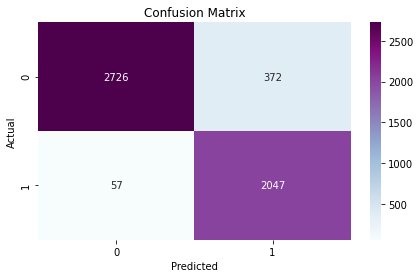

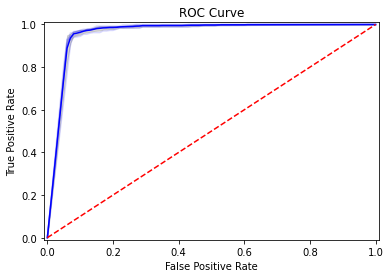

In [63]:
model = GaussianNB
clf, mean_accuracy_nb, mean_precision_nb, mean_recall_nb, roc_nb, pr_nb = apply_cross_validation(model)

Como pode ser visto acima as métricas utilizadas para avaliação do modelo foram:
  - $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$
  - $Precision = \frac{TP}{TP + FP}$
  - $Recall = \frac{TP}{TP + FN}$
 
sendo:
  - True Positive (TP):  A classe positiva real é prevista como positiva.
  - True Negative (TN):  A classe negativa real é predita negativa.
  - False Positive (FP): A classe real é negativa, mas prevista como positiva. 
  - False Negative (FN): A classe real é positiva, mas prevista como negativa.
  
Bacicamente, acurácia é simplesmente uma proporção das observações corretamente previstas para o total de observações. Precisão é a razão de observações positivas previstas corretamente para o total de observações positivas previstas. E Recall é a proporção de observações positivas corretamente previstas para todas as observações positivas. Em todas essas métricas, quanto mais próximo de 1 (ou 100%, considerando resultados percentuais), melhor o resultado.

Como pode ser notado acima, para o modelo Naive Bayes, utilizado como baseline, os resultados médios obtidos da execução de um 5-fold cross-validation foram:

Mean Accuracy: 0.9175+/-0.0066
Mean Precision: 0.8459+/-0.0132
Mean Recall: 0.9727+/-0.0070

Além disso, foram plotados a matriz de confusão e a curva ROC obtidas. A matriz de confusão é basicamente uma tabela que permite a visualização do desempenho de um algoritmo, tipicamente de aprendizado supervisionado. Cada linha da matriz representa as instâncias de uma classe real enquanto cada coluna representa as instâncias de uma classe prevista. Quanto maior os valores na diagonal principal e menor os outros valores, melhor será o desempenho do modelo (isso pode ser observado na matriz de confusão acima). Já a curva ROC é criada plotando a taxa de verdadeiros positivos (TPR) em relação à taxa de falsos positivos (FPR) em diferentes limiares de classificação. Uma maneira de se analisar a curva ROC é através da área abaixo da curva, quanto maior ela for, melhor é o resultado.

## Decision Tree

O primeiro teste será a realização de um *grid search* variando o comprimento máximo da árvore entre 1 e 10, e também com comprimento ilimitado. Variar esse parâmetro resulta em modelos com capacidades diferentes: árvores maiores têm mais complexidade do que árvores pequenas, o que é bom para reduzir o erro de treinamento. No entanto, pode levar o modelo a overfitting, o que não queremos, pois piorará a generalização do modelo. Abaixo é possível observar o resultado obtido com a realização do *grid search*.

In [64]:
lst = list(range(1,11))
lst.append(None)
# Grid Search application
grid_params_DecisionTree = [{'DecisionTreeClassifier__max_depth': lst}]
pipe_tree = Pipeline([('scaler',  MinMaxScaler()),
            ('DecisionTreeClassifier', DecisionTreeClassifier())])
clf = GridSearchCV(pipe_tree, grid_params_DecisionTree , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('DecisionTreeClassifier',
                                        DecisionTreeClassifier())]),
             param_grid=[{'DecisionTreeClassifier__max_depth': [1, 2, 3, 4, 5,
                                                                6, 7, 8, 9, 10,
                                                                None]}],
             scoring='accuracy', verbose=1)

In [65]:
max_depth = clf.best_params_['DecisionTreeClassifier__max_depth']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for max_depth = " + str(max_depth) )

The best mean accuracy was 0.9469 and was achieved for max_depth = 6


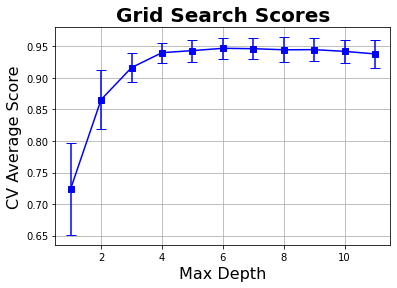

In [66]:
def plot_grid_search(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean)
    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd)

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)
    ax.errorbar(grid_param_1, scores_mean, scores_sd, color = 'blue', marker='s', capsize=5)

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')
    
# Calling Method 
lst = list(range(1,12))
plot_grid_search(clf.cv_results_, lst, 'Max Depth')

Accuracy (fold 1): 0.9491
Accuracy (fold 2): 0.9452
Accuracy (fold 3): 0.9462
Accuracy (fold 4): 0.9596
Accuracy (fold 5): 0.9519

Mean Accuracy: 0.9504+/-0.0052
Mean Precision: 0.9205+/-0.0098
Mean Recall: 0.9599+/-0.0084


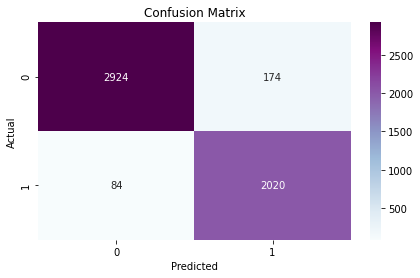

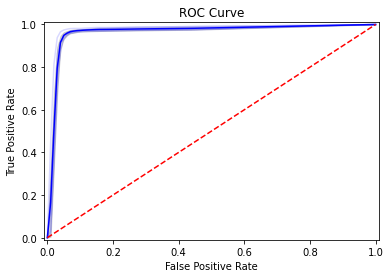

In [67]:
model = DecisionTreeClassifier
params = {'max_depth' : max_depth}
clf, mean_accuracy_dt, mean_precision_dt, mean_recall_dt, roc_dt, pr_dt = apply_cross_validation(model, params)

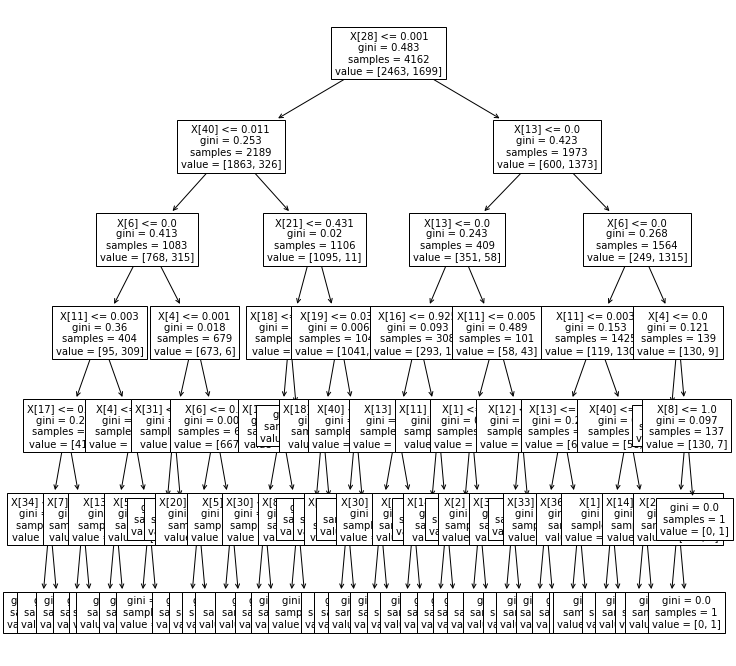

In [68]:
# plot tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=10)
plt.show()

## SVM

### SVM Kernel Linear

Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best mean accuracy was 0.9441 and was achieved for C = 100.0


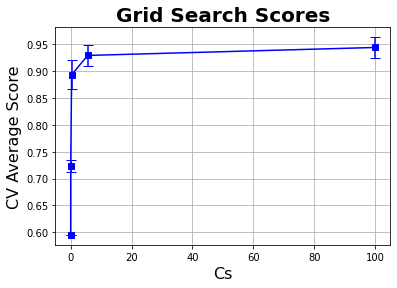

In [69]:
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="linear"))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
#Results of Grid Seach:
C  = clf.best_params_['SVM__C']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) )
plot_grid_search(clf.cv_results_, lst, 'Cs')

Accuracy (fold 1): 0.9443
Accuracy (fold 2): 0.9472
Accuracy (fold 3): 0.9433
Accuracy (fold 4): 0.9442
Accuracy (fold 5): 0.9538

Mean Accuracy: 0.9466+/-0.0039
Mean Precision: 0.9124+/-0.0078
Mean Recall: 0.9602+/-0.0048


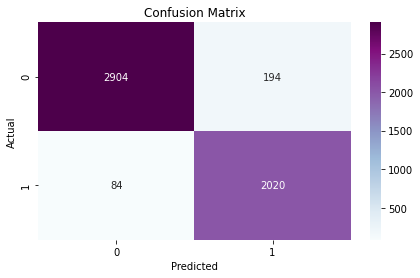

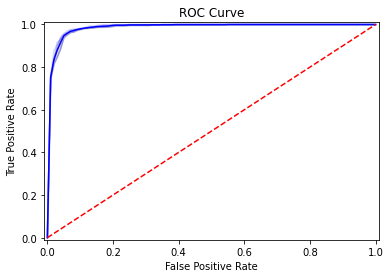

In [70]:
model = svm.SVC
params = {'kernel' : "linear", 'C' : C, 'probability' : True}
clf, mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm, roc_linear_svm, pr_lsvm = apply_cross_validation(model, params)

### SVM Kernel Sigmoid

In [71]:
def plot_grid_search_2_params(searcher, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = searcher.cv_results_['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1), len(grid_param_2)).T
    scores_sd = searcher.cv_results_['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_1), len(grid_param_2)).T
    print('Best params = {}'.format(searcher.best_params_))
    print('Best score = {}'.format(scores_mean.max()))
    _, ax = plt.subplots(1,1)
    
    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.errorbar(grid_param_1, scores_mean[idx, :], scores_sd, marker='s', capsize=5, label=name_param_2 + ': ' + str(val))
    
    ax.tick_params(axis='x')
    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.grid('on')
    ax.legend(loc='best')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best mean accuracy was 0.9216 and was achieved for C = 100.0and gamma = auto
Best params = {'SVM__C': 100.0, 'SVM__gamma': 'auto'}
Best score = 0.9215759624621297


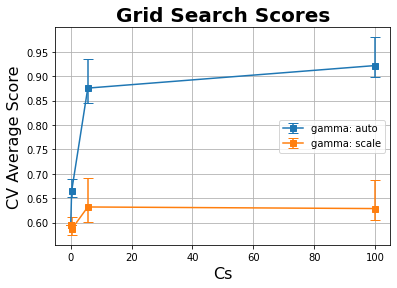

In [72]:
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst,
                   'SVM__gamma' : ['auto', 'scale']}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="sigmoid"))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
gamma = clf.best_params_['SVM__gamma']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) + "and gamma = " + str(gamma) )
plot_grid_search_2_params(clf, lst, ['auto', 'scale'], 'Cs', 'gamma')

Accuracy (fold 1): 0.9203
Accuracy (fold 2): 0.9241
Accuracy (fold 3): 0.9221
Accuracy (fold 4): 0.9250
Accuracy (fold 5): 0.9279

Mean Accuracy: 0.9239+/-0.0026
Mean Precision: 0.8745+/-0.0083
Mean Recall: 0.9478+/-0.0077


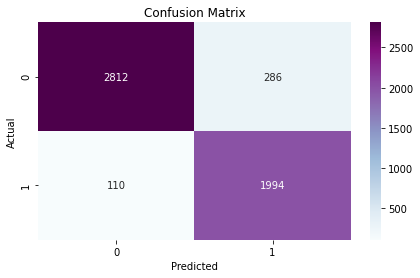

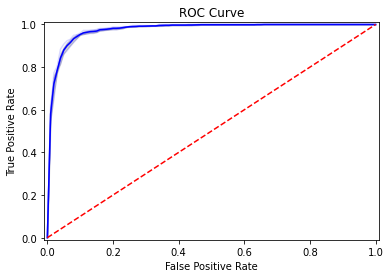

In [74]:
model = svm.SVC
params = {'kernel' : "sigmoid", 'gamma' : gamma, 'C' : C, 'probability' : True}
clf, mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm, roc_sigmoid_svm, pr_ssvm= apply_cross_validation(model, params)

### SVM Kernel Polinomial

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best mean accuracy was 0.9448 and was achieved for C = 100.0and gamma = scale
Best params = {'SVM__C': 100.0, 'SVM__gamma': 'scale'}
Best score = 0.944833185546442


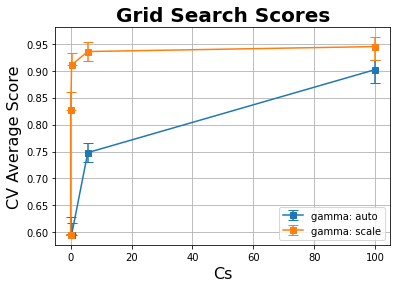

In [75]:
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst,
                   'SVM__gamma' : ['auto', 'scale']}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="poly", gamma='scale'))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
gamma = clf.best_params_['SVM__gamma']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) + "and gamma = " + str(gamma) )
plot_grid_search_2_params(clf, lst, ['auto', 'scale'], 'Cs', 'gamma')

Accuracy (fold 1): 0.9472
Accuracy (fold 2): 0.9472
Accuracy (fold 3): 0.9481
Accuracy (fold 4): 0.9500
Accuracy (fold 5): 0.9471

Mean Accuracy: 0.9479+/-0.0011
Mean Precision: 0.9166+/-0.0062
Mean Recall: 0.9581+/-0.0067


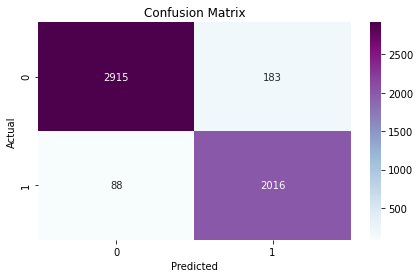

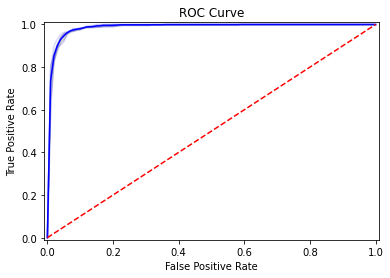

In [76]:
model = svm.SVC
params = {'kernel' : "poly", 'gamma' : gamma, 'C' : C, 'probability' : True}
clf, mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm, roc_poly_svm, pr_psvm = apply_cross_validation(model, params)

### SVM Kernel RBF

Fitting 5 folds for each of 10 candidates, totalling 50 fits
The best mean accuracy was 0.9371 and was achieved for C = 100.0and gamma = scale
Best params = {'SVM__C': 100.0, 'SVM__gamma': 'scale'}
Best score = 0.9371438335919604


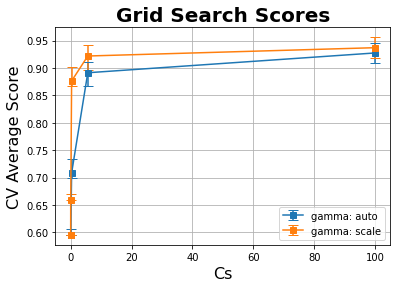

In [78]:
lst = np.logspace(-3, 2, 50)
# Grid Search application
grid_params_svm = [{'SVM__C': lst,
                   'SVM__gamma' : ['auto', 'scale']}]
pipe_svm = Pipeline([('scaler',  MinMaxScaler()),
            ('SVM', svm.SVC(kernel="rbf", gamma='scale'))])
clf = GridSearchCV(pipe_svm, grid_params_svm , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
C  = clf.best_params_['SVM__C']
gamma = clf.best_params_['SVM__gamma']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for C = " + str(C) + "and gamma = " + str(gamma) )
plot_grid_search_2_params(clf, lst, ['auto', 'scale'], 'Cs', 'gamma')

Accuracy (fold 1): 0.9414
Accuracy (fold 2): 0.9414
Accuracy (fold 3): 0.9365
Accuracy (fold 4): 0.9433
Accuracy (fold 5): 0.9481

Mean Accuracy: 0.9421+/-0.0037
Mean Precision: 0.9022+/-0.0095
Mean Recall: 0.9612+/-0.0039


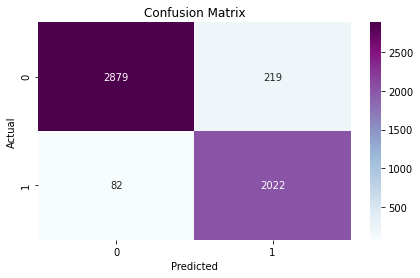

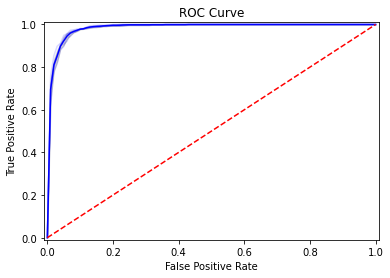

In [79]:
model = svm.SVC
params = {'kernel' : "rbf", 'gamma' : gamma, 'C': C, 'probability' : True}
clf, mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm, roc_rbf_svm, pr_rsvm = apply_cross_validation(model, params)

In [80]:
data = [["SVM Kernel", 'Accuracy', 'Precision', 'Recall'],
        ["Linear", mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm],
        ["Sigmoid", mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm],
        ["Poly", mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm],
        ["RBF", mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm]]
table = tabulate.tabulate(data, tablefmt='grid')
print(table)

+------------+-----------------+-----------------+-----------------+
| SVM Kernel | Accuracy        | Precision       | Recall          |
+------------+-----------------+-----------------+-----------------+
| Linear     | 0.9466+/-0.0039 | 0.9124+/-0.0078 | 0.9602+/-0.0048 |
+------------+-----------------+-----------------+-----------------+
| Sigmoid    | 0.9239+/-0.0026 | 0.8745+/-0.0083 | 0.9478+/-0.0077 |
+------------+-----------------+-----------------+-----------------+
| Poly       | 0.9479+/-0.0011 | 0.9166+/-0.0062 | 0.9581+/-0.0067 |
+------------+-----------------+-----------------+-----------------+
| RBF        | 0.9421+/-0.0037 | 0.9022+/-0.0095 | 0.9612+/-0.0039 |
+------------+-----------------+-----------------+-----------------+


## k-NN

Fitting 5 folds for each of 5 candidates, totalling 25 fits
The best mean accuracy was 0.8320 and was achieved for K = 26


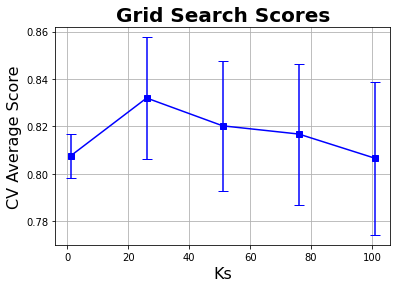

In [81]:
lst =  list(np.linspace(1, 101, 51, dtype=int))
# Grid Search application
grid_params_knn = [{'knn__n_neighbors': lst}]
pipe_knn = Pipeline([('scaler',  MinMaxScaler()),
            ('knn', KNeighborsClassifier())])
clf = GridSearchCV(pipe_knn, grid_params_knn , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
k  = clf.best_params_['knn__n_neighbors']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for K = " + str(k) )
plot_grid_search(clf.cv_results_, lst, 'Ks')

Accuracy (fold 1): 0.8463
Accuracy (fold 2): 0.8280
Accuracy (fold 3): 0.8462
Accuracy (fold 4): 0.8356
Accuracy (fold 5): 0.8240

Mean Accuracy: 0.8360+/-0.0091
Mean Precision: 0.7330+/-0.0247
Mean Recall: 0.9356+/-0.0219


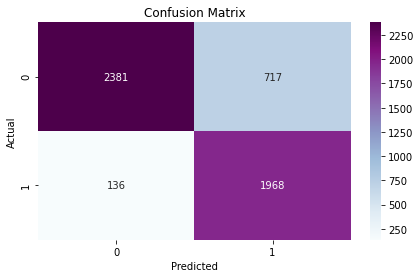

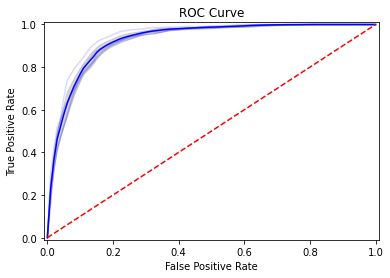

In [82]:
model = KNeighborsClassifier
params = {'n_neighbors' : k}
clf, mean_accuracy_knn, mean_precision_knn, mean_recall_knn, roc_knn, pr_knn = apply_cross_validation(model, params)

## Random Forest

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best mean accuracy was 0.9635 and was achieved for n_estimators = 90


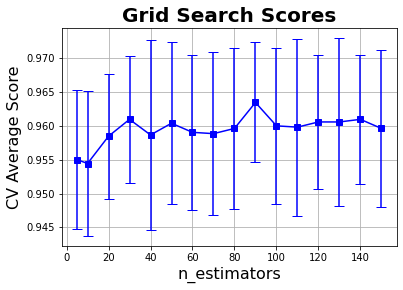

In [83]:
lst =  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_random_forest = [{'RandomForest__n_estimators': lst}]
pipe_random_forest = Pipeline([('scaler',  MinMaxScaler()),
            ('RandomForest', RandomForestClassifier(max_depth = max_depth))])
clf = GridSearchCV(pipe_random_forest, grid_params_random_forest , scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['RandomForest__n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 1): 0.9635
Accuracy (fold 2): 0.9549
Accuracy (fold 3): 0.9615
Accuracy (fold 4): 0.9683
Accuracy (fold 5): 0.9702

Mean Accuracy: 0.9637+/-0.0054
Mean Precision: 0.9450+/-0.0084
Mean Recall: 0.9660+/-0.0088


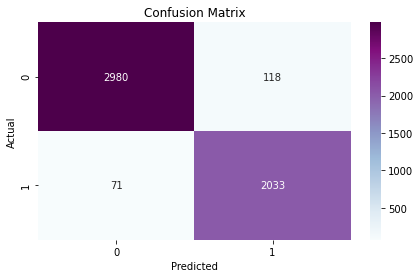

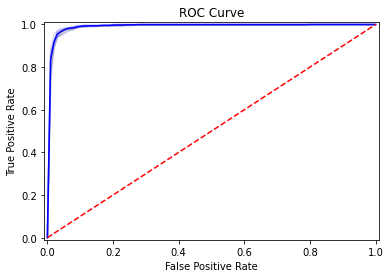

In [84]:
model = RandomForestClassifier
params = {'n_estimators' : n_estimators, "max_depth" : max_depth}
clf, mean_accuracy_rf, mean_precision_rf, mean_recall_rf, roc_rf, pr_rf = apply_cross_validation(model, params)

## Gradient Tree Boosting

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best mean accuracy was 0.9717 and was achieved for n_estimators = 140


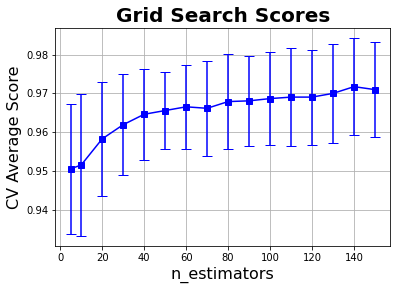

In [85]:
lst =  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
# Grid Search application
# The max depth will be the value encountered in Decision Tree test
grid_params_gradient_boosting = [{'GradientBoosting__n_estimators': lst}]
pipe_gradient_boosting = Pipeline([('scaler',  MinMaxScaler()),
            ('GradientBoosting', GradientBoostingClassifier(max_depth = max_depth))])
clf = GridSearchCV(pipe_gradient_boosting, grid_params_gradient_boosting, scoring='accuracy', refit=True, cv=5, verbose=1)
# Run fit with all sets of parameters.
clf.fit(X, y)
# Results of Grid Search
n_estimators  = clf.best_params_['GradientBoosting__n_estimators']
score = clf.best_score_
print("The best mean accuracy was " + '{:.4f}'.format(score) + " and was achieved for n_estimators = " + str(n_estimators) )
plot_grid_search(clf.cv_results_, lst, 'n_estimators')

Accuracy (fold 1): 0.9741
Accuracy (fold 2): 0.9750
Accuracy (fold 3): 0.9712
Accuracy (fold 4): 0.9837
Accuracy (fold 5): 0.9760

Mean Accuracy: 0.9760+/-0.0042
Mean Precision: 0.9640+/-0.0087
Mean Recall: 0.9770+/-0.0083


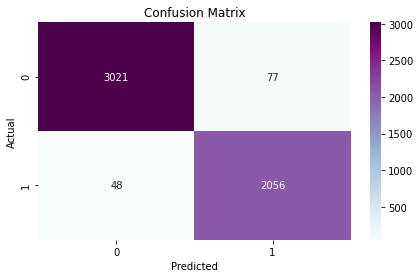

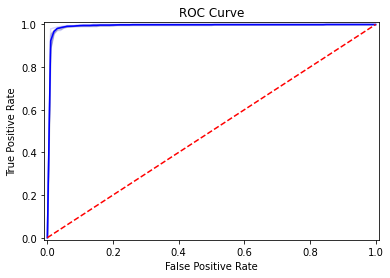

In [86]:
model = GradientBoostingClassifier
params = {'n_estimators' : n_estimators, "max_depth" : max_depth}
clf, mean_accuracy_gb, mean_precision_gb, mean_recall_gb, roc_gb, pr_gb = apply_cross_validation(model, params)

## Comparação Entre os Métodos

### Accuracy, Precision and Recall

In [87]:
data = [["Método", 'Accuracy', 'Precision', 'Recall'],
        ["Naive Bayes", mean_accuracy_nb, mean_precision_nb, mean_recall_nb],
        ["Decision Tree", mean_accuracy_dt, mean_precision_dt, mean_recall_dt],
        ["SVM (Linear)", mean_accuracy_linear_svm, mean_precision_linear_svm, mean_recall_linear_svm],
        ["SVM (Sigmoid)", mean_accuracy_sigmoid_svm, mean_precision_sigmoid_svm, mean_recall_sigmoid_svm],
        ["SVM (Poly)", mean_accuracy_poly_svm, mean_precision_poly_svm, mean_recall_poly_svm],
        ["SVM (RBF)", mean_accuracy_rbf_svm, mean_precision_rbf_svm, mean_recall_rbf_svm],
        ["k-NN", mean_accuracy_knn, mean_precision_knn, mean_recall_knn],
        ["Random Forest", mean_accuracy_rf, mean_precision_rf, mean_recall_rf],
        ["Gradient Tree Boosting", mean_accuracy_gb, mean_precision_gb, mean_recall_gb]]
table = tabulate.tabulate(data, tablefmt='grid')
print(table)

+------------------------+-----------------+-----------------+-----------------+
| Método                 | Accuracy        | Precision       | Recall          |
+------------------------+-----------------+-----------------+-----------------+
| Naive Bayes            | 0.9175+/-0.0066 | 0.8459+/-0.0132 | 0.9727+/-0.0070 |
+------------------------+-----------------+-----------------+-----------------+
| Decision Tree          | 0.9504+/-0.0052 | 0.9205+/-0.0098 | 0.9599+/-0.0084 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Linear)           | 0.9466+/-0.0039 | 0.9124+/-0.0078 | 0.9602+/-0.0048 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Sigmoid)          | 0.9239+/-0.0026 | 0.8745+/-0.0083 | 0.9478+/-0.0077 |
+------------------------+-----------------+-----------------+-----------------+
| SVM (Poly)             | 0.9479+/-0.0011 | 0.9166+/-0.0062 | 0.9581+/-0.0067 |
+------------------------+--

### ROC Curve

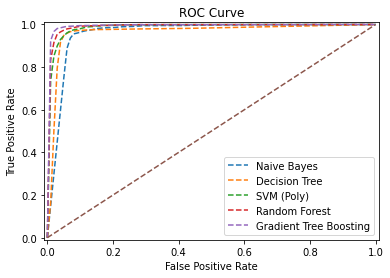

In [88]:
plt.figure(figsize=(6,4))
base_fpr = np.linspace(0, 1, 101)
# Plot mean ROC curve for all methods in the same graph
plt.plot(base_fpr, roc_nb.mean(axis=0), linestyle='--', label='Naive Bayes')
plt.plot(base_fpr, roc_dt.mean(axis=0), linestyle='--', label='Decision Tree')
#plt.plot(base_fpr, roc_linear_svm.mean(axis=0), linestyle='--', label='SVM (Linear)')
#plt.plot(base_fpr, roc_sigmoid_svm.mean(axis=0), linestyle='--', label='SVM (Sigmoid)')
#plt.plot(base_fpr, roc_rbf_svm.mean(axis=0), linestyle='--', label='SVM (RBF)')
plt.plot(base_fpr, roc_poly_svm.mean(axis=0), linestyle='--', label='SVM (Poly)')
plt.plot(base_fpr, roc_rf.mean(axis=0), linestyle='--', label='Random Forest')
plt.plot(base_fpr, roc_gb.mean(axis=0), linestyle='--', label='Gradient Tree Boosting')
plt.plot([0, 1], [0, 1],'--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.show()

### Precision-Recall Curve

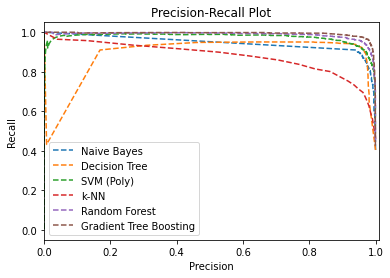

In [90]:
# Plot Precision-Recall curve for all methods in the same graph
plt.plot(pr_nb[1], pr_nb[0], linestyle='--', label='Naive Bayes')
plt.plot(pr_dt[1], pr_dt[0], linestyle='--', label='Decision Tree')
#plt.plot(pr_lsvm[1], pr_lsvm[0], linestyle='--', label='SVM (Linear)')
#plt.plot(pr_ssvm[1], pr_ssvm[0], linestyle='--', label='SVM (Sigmoid)')
#plt.plot(pr_rsvm[1], pr_rsvm[0], linestyle='--', label='SVM (RBF)')
plt.plot(pr_psvm[1], pr_psvm[0], linestyle='--', label='SVM (Poly)')
plt.plot(pr_knn[1], pr_knn[0], linestyle='--', label='k-NN')
plt.plot(pr_rf[1], pr_rf[0], linestyle='--', label='Random Forest')
plt.plot(pr_gb[1], pr_gb[0], linestyle='--', label='Gradient Tree Boosting')
plt.title('Precision-Recall Plot')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.xlim([0, 1.01])
plt.legend() 
plt.show()